<div align="center">

---
# ML1 | AdaBoost Classifier 
Analysis & Optimization
-
---
</div>

<div align = "center">

--- 
## Project Overview
---
</div>

In recent years, the rise of Artificial Intelligence and the widespread use of Machine Learning have revolutionized the way we tackle complex real-world challenges. However, due to the diverse nature of data involved, choosing the right algorithm is crucial to achieve efficient and effective solutions. Therefore, understanding the strengths and weaknesses behind different Machine Learning algorithms, and knowing how to adapt them to meet specific challenges, can become a fulcral skill to develop.

Furthermore, since the choice of algorithm greatly depends on the specific task and data involved, it's clear that there is no "Master Algorithm" (No algorithm can solve every problem). For example, while Linear Discriminants effectively delineate boundaries in data that is linearly separable, they struggle to capture relationships in more complex, higher-dimensional spaces.

This Project focuses on the following topic:

> With no Master Algorithm, is it possible to improve a existing Machine Learning Algorithm in characteristics it struggles the most?

Therefore, after choosing a Machine Learning algorithm and gaining a thorough understanding of its theoretical and empirical aspects, we aim to refine it, specifically targeting its weaknesses in solving classification problems.

<div align = "center">

--- 
## Classifier Selection
---
</div>

Nowadays, since some Machine Learning Algorithms can fall short to predict the whole data given, we decided to study an Ensemble Algorithm. Since these Algorithms can combine outputs of multiple models it makes them more prone to better address more complex problems and therefore provide better solutions. Consequently this new types of algorithms tend to have a better performance which contributes for a overall better algorithm.

Additionally, after careful consideration, we decided to focus on enhancing the AdaBoost Algorithm M1, which is employed in binary classification problems.

<center><img src="./Assets/Boosting.gif" width="500" title="Boosting"></center>

<div align = "center">

--- 
## AdaBoost Overview
---
</div>

**AdaBoost** (Adaptive Boosting) is a type of ensemble learning technique used in machine learning to solve both **classification** and **regression** problems. It consists on training a series of weak classifiers on the dataset. Therefore, with each iteration, the algorithm **increases the focus** on data points that were **previously predicted incorrectly**.

As a result, the AdaBoost algorithm builds a model by considering all the individual **weak classifiers** which are **weighted based on their performance**. Consequently, classifiers with **higher predictive accuracy contribute more to the final decision** which **reduces the influence of less accurate ones** in the final prediction. 

Finally, here's the **pseudocode** behind the AdaBoost M1 Algorithm used in this Notebook:

<div align = "center">

--- 
### AdaBoost.M1 [Pseudocode]
---
</div>

1. Initialize the observation weights $w_i = \frac{1}{N}$, for $i = 1, 2, \dots, N$.

2. For $ m = 1 $ to $ M $:
   \
   a) Fit a classifier $ G_m(x) $ to the training data using weights $ w_i $
   \
   b) Compute
      $$
      \text{err}_m = \frac{ \sum_{i=1}^N w_i I(y_i \neq G_m(x_i)) }{ \sum_{i=1}^N w_i }
      $$
   c) Compute $ \alpha_m = \log\left(\frac{1 - \text{err}_m}{\text{err}_m}\right) $
   \
   \
   d) Set $ w_i \leftarrow w_i \cdot \exp\left(\alpha_m \cdot I(y_i \neq G_m(x_i))\right) $, for $ i = 1, 2, \dots, N $.

4. Output $ G(x) = \text{sign}\left( \sum_{m=1}^M \alpha_m G_m(x) \right) $.


> **Source**: *The Elements of Statistical Learning, ch. 10*

<div align = "center">

--- 
### AdaBoost.M1 [Step Guide]
---
</div>

As previously discussed, AdaBoost techniques combine many weak machine-learning models to create a **powerful classification model** for the output which envolves the following steps:

1. **Initialize the Weights**
    - For a dataset with $N$ training data points instances, initialize $N W_{i}$ weights for each data point with $W_{i} = \frac{1}{N}$

<p></p>

2. **Train Weak Classifiers**
    - Train a weak classifier $M_k$ where $k$ is the current iteration
    - The weak classifier we are training should have an accuracy greater than 0.5 which means it should be performing better than a naive guess

<p></p>

3. Calculate the **Error Rate** and **importance of each weak model $M_k$**
    - Calculate rate $error\_rate$ for every weak classifier $M_k$ on the training dataset
    - Calculate the importance of each model $α\_k$ using formula $\alpha_k = \frac{1}{2} \ln{\frac{1 – error_k}{error_k}}$

<p></p>

4. **Update** data point **weight** for each data point $W_i$:
    - After applying the weak classifier model to the training data we will update the weight assigned to the points using the accuracy of the model. The formula for updating the weights will be $w_i = w_i \exp{(-\alpha_k y_i M_k(x_i))}$. Here $y_i$ is the true output and $X_i$ is the corresponding input vector

<p></p>

5. **Normalize the Instance weight**
    - We will normalize the instance weight so that they can be summed up to 1 using the formula $W_i = W_i / sum(W)$

<p></p>

6. **Repeat steps 2-5 for $K \space iterations$**
    - We will train $K \space classifiers$ and will calculate model importance and update the instance weights using the above formula
    - The final model $M(X)$ will be an ensemble model which is obtained by combining these weak models weighted by their model weights

Theoretically the **AdaBoost Algorithm** can use any Machine Learning algorithm as **Weak Learners**. However, depending on the **problem and data** at hand, the final model might require a **more delicate** approach on it's **evaluation**. Therefore the **best** algorithms to use as **weak learners** are typically those that are **fast**, **simple** and slightly **better than random guess** which is why we started developing AdaBoost with **Stumps** (Decision Trees of Depth 1). 

<div align = "center">

--- 
### AdaBoost.M1 [Disadvantages]
---
</div>

Despite the Algorithms powerfull techinques, it yet remains limited by a few factors.

#### Noisy Data and Outliers

For instance, if the AdaBoost algorithm is used upon noisy data, it can focus too much on correcting previous misclassifications despite their actual trends, which can lead to overfitting. 

Moreover, outliers can also impact the algorithm's performance significantly. Since AdaBoost tries to perfectly fit each example, it can overlook on rare instances in the data rather than finding the actual patterns within it.

#### Choice of Weak Learner

Furthermore, AdaBoost can be quite sensitive to the Weak Learners used. As previously mentioned, the best weak models are often described as simple, fast and with low variance. Therefore, they do not memorize the training data but rather learn to generalize different aspects within the data.

#### Computational Cost

Since AdaBoost consists of a Boosting Algorithm, it's performance mainly depends on the amount of boosting rounds performed during training. This main hyperparameter can easily affect the model's effectiveness which can lead to overfitting as well as to high computational costs.

<div align = "center">

--- 
## Importing Dependencies
---
</div>

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

# Import Project's Dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split, KFold, cross_val_score)
from sklearn.metrics import (accuracy_score, roc_curve, roc_auc_score)
from sklearn.utils import (shuffle)
from sklearn.datasets import (make_classification)
from sklearn.ensemble import (AdaBoostClassifier)
import scikit_posthocs as sp
from scipy.stats import (friedmanchisquare)
import openml

from AdaBoostStudy.AdaBoost import (AdaBoost)
from AdaBoostStudy.DataPreprocessing import (Fetch_Dataset, Fetch_X_y)
from AdaBoostStudy.ModifiedAdaBoost import (AdaBoostTunedDT, AdaBoostPerceptron, AdaBoostRidgeClassifier, AdaBoost_LogisticLoss, AdaBoost_HingeLoss, AdaBoost_SquaredLoss)
from AdaBoostStudy.ModelEvaluation import (Perform_KFold_CV, Perform_Mean_KFold_CV, Evaluate_Model, Evaluate_Model_AllDS, Evaluate_Models)
from AdaBoostStudy.DataVisualization import (Compare_Models_Accuracies, Display_Confusion_Matrix, Plot_ROC_Curve, Plot_Weak_Learners_Stats, Plot_Model_Stats, Compare_Models_Stats, Model_Accuracies_Per_Dataset, Plot_Critial_Difference_Diagram)

<div align = "center">

--- 
## Data Preprocessing [Datasets Selection]
---
</div>

Since the developed AdaBoost Algorithm focuses on Binary Classification Problems, we decided to filter all the datasets inside the `OpenML-CC18 Curated Classification` study. Therefore, by selecting those with 2 possible target values we will can ensure a proper training of our Models.

In [17]:
# List all tasks in the 'OpenML-CC18' benchmark
benchmark = openml.study.get_suite('OpenML-CC18')
df_tasks = openml.tasks.list_tasks(output_format="dataframe", task_id=benchmark.tasks)
df_tasks.head()

,tid,ttid,did,name,task_type,status,estimation_procedure,source_data,target_feature,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
3,3,TaskType.SUPERVISED_CLASSIFICATION,3,kr-vs-kp,Supervised Classification,active,10-fold Crossvalidation,3,class,1669,3.0,1527,2,37,3196,0,0,0,37
6,6,TaskType.SUPERVISED_CLASSIFICATION,6,letter,Supervised Classification,active,10-fold Crossvalidation,6,class,813,26.0,734,26,17,20000,0,0,16,1
11,11,TaskType.SUPERVISED_CLASSIFICATION,11,balance-scale,Supervised Classification,active,10-fold Crossvalidation,11,class,288,3.0,49,3,5,625,0,0,4,1
12,12,TaskType.SUPERVISED_CLASSIFICATION,12,mfeat-factors,Supervised Classification,active,10-fold Crossvalidation,12,class,200,10.0,200,10,217,2000,0,0,216,1
14,14,TaskType.SUPERVISED_CLASSIFICATION,14,mfeat-fourier,Supervised Classification,active,10-fold Crossvalidation,14,class,200,10.0,200,10,77,2000,0,0,76,1


In [18]:
# Creating a Dictionary to store each dataset's information
my_tasks = {}

for task_id in df_tasks.loc[df_tasks['NumberOfClasses'] == 2]['tid'].to_numpy():
    name, ds = Fetch_Dataset(task_id)
    
    target_values = list(np.unique(ds['target']))
    
    if (len(target_values) > 0 and task_id not in my_tasks.keys()):
        
        features = list(ds.columns[:-1])
        target = ds.columns[-1]
        
        content = {'Name':name,
                   'Features':features,
                   'Target':target,
                   'TargetValues':target_values}
        
        my_tasks.update({task_id: content})

In [19]:
# Display all the datasets selected
for task_id, info_task in my_tasks.items():
    name, ds = Fetch_Dataset(task_id)
    print(f"[Dataset ID {task_id}]: {info_task['Name']}\n")
    print(f"[Features]: {info_task['Features']}", '\n')
    print(f"[Target]: {info_task['Target']}", '\n')
    print(f"[Target Values]: {info_task['TargetValues']}", '\n')
    print('-'*30, '\n')

[Dataset ID 3]: kr-vs-kp

[Features]: ['bkblk', 'bknwy', 'bkon8', 'bkona', 'bkspr', 'bkxbq', 'bkxcr', 'bkxwp', 'blxwp', 'bxqsq', 'cntxt', 'dsopp', 'dwipd', 'hdchk', 'katri', 'mulch', 'qxmsq', 'r2ar8', 'reskd', 'reskr', 'rimmx', 'rkxwp', 'rxmsq', 'simpl', 'skach', 'skewr', 'skrxp', 'spcop', 'stlmt', 'thrsk', 'wkcti', 'wkna8', 'wknck', 'wkovl', 'wkpos', 'wtoeg'] 

[Target]: target 

[Target Values]: [-1, 1] 

------------------------------ 

[Dataset ID 15]: breast-w

[Features]: ['Clump_Thickness', 'Cell_Size_Uniformity', 'Cell_Shape_Uniformity', 'Marginal_Adhesion', 'Single_Epi_Cell_Size', 'Bare_Nuclei', 'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses'] 

[Target]: target 

[Target Values]: [-1, 1] 

------------------------------ 

[Dataset ID 29]: credit-approval

[Features]: ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15'] 

[Target]: target 

[Target Values]: [-1, 1] 

------------------------------ 

[Dataset ID 31]: credit-g

[Featur

<div align = "center">

--- 
## Base Model Evaluation
---
</div>

Initially we started by evaluating the Algorithm to obtain ground results that can be later used against further new modified versions. Therefore, by performing a K-Fold Cross Validation upon all the choosen datasets we were able to determine an estimate of the Model's overall Accuracy.


In [5]:
try:
    # Model Already Evaluated with the results Stored
    Base_Results = pd.read_csv('./Experimental Results/AdaBoost_Base_Results.csv')
except:
    # Evaluating the Base Model as well as the Sklearn's version
    Base_Results = Evaluate_Models(my_tasks, [AdaBoost(), AdaBoostClassifier()], ['Dataset', 'AdaBoost [Base]', 'AdaBoost [Sklearn]'])
    Base_Results.to_csv('./Experimental Results/AdaBoost_Base_Results.csv', index=False)

Base_Results

,Dataset,AdaBoost [Base],AdaBoost [Sklearn]
0,kr-vs-kp,0.940859,0.964325
1,breast-w,0.963418,0.956086
2,credit-approval,0.872860,0.849877
3,credit-g,0.758000,0.753000
4,diabetes,0.769612,0.751354
5,spambase,0.933927,0.940009
6,tic-tac-toe,0.732755,0.773467
7,electricity,0.770635,0.811728
8,pc4,0.893019,0.901923
9,pc3,0.895072,0.885476


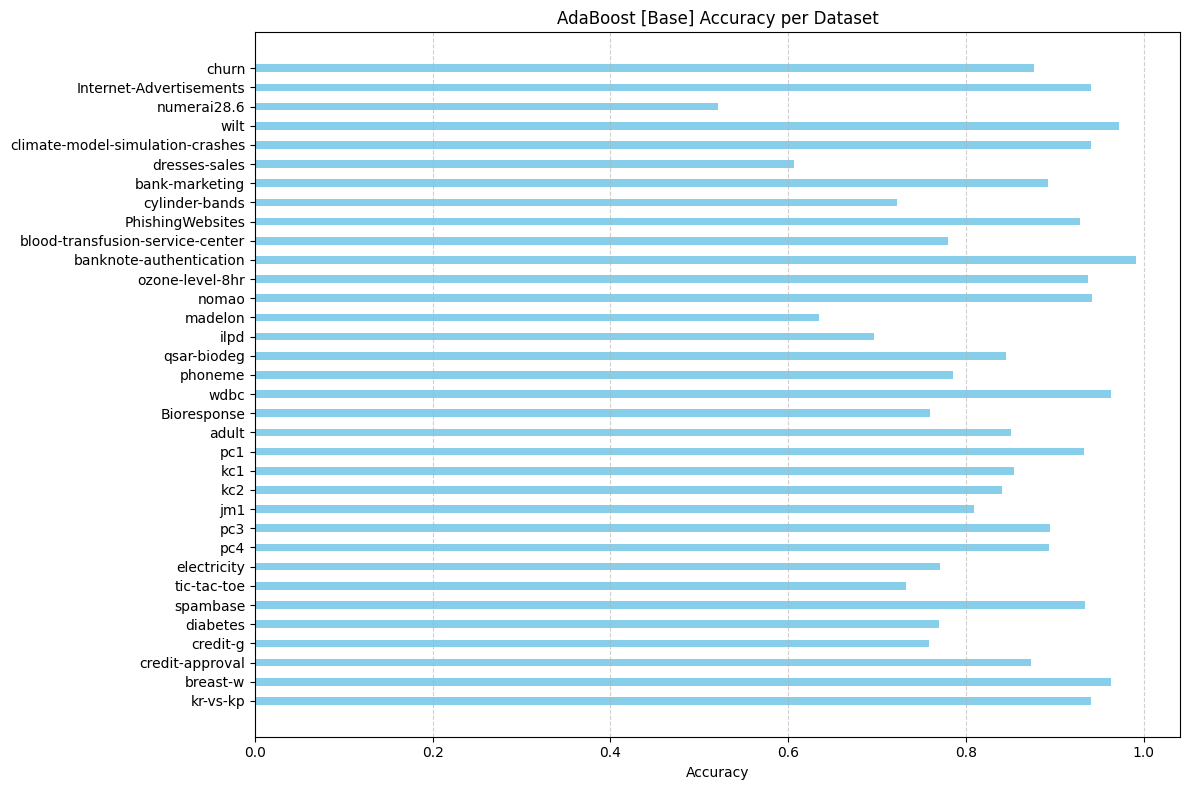

In [6]:
# Plotting the Base Reults of our algoritm's base implementation
Model_Accuracies_Per_Dataset(Base_Results, 'AdaBoost [Base]')

In order to dive deeper on how the Algorithm performs we dicided to evaluate it against the `Breast-W Dataset` with the following concepts:

- **Weak Learner's Training Error**
  - Evaluating how the weak learner's **error evolves during training** can provide great insights on how they affect the overall algorithm.
- **Weak Learner's Weights**
  - The weights of each weak learner can help understand the **impact of each classifier on the final decision**.
- **Confusion Matrix**
  - Matrix that conveys the model's **classification results** (TP, TN, FP, FN).
- **ROC Curve**
  - Provides a great understanding of the **model's tradeoffs** between both **true positive and false positive rates**.
  - Alongside the ROC Cuve, the **AUC (Area Under Curve)** also helps quantify the model's classification **performance**.

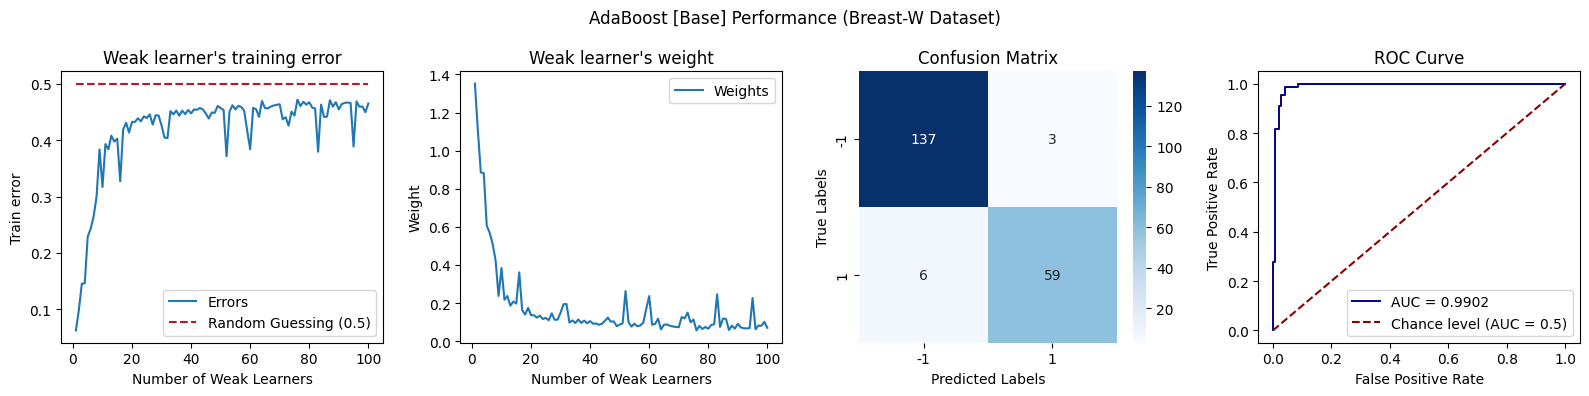

In [7]:
# Model Performance Evaluation on the Breast-W Dataset (Task ID 15)
name, X, y = Fetch_X_y(task_id=15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
ab = AdaBoost()
ab.fit(X_train, y_train)
Plot_Model_Stats(ab, X_test, y_test, "AdaBoost [Base] Performance (Breast-W Dataset)")

<div align = "center">

--- 
## AdaBoost.M1 [Improvements]
---
</div>

<div align = "center">

In this Section we focus on tempering with the algorithm's disadvantages in order to make it better. Therefore, by performing statistical inference upon the behaviour of the new modified models on the selected datasets, we are capable of infering the algorithm's improvement face the previous control results.

<div align="center">

--- 
### Choice of Weak Learners
---
</div>

After considering the disadvantages behind the Algorithm we came up with a few possible modifications that could tackle some of it's problems.

Firstly we started by assessing how the choice of Weak Learners could impact the Algorithm's Performance. Therefore, we considered using:

- Decision Trees with Increased Depth
  - In AdaBoost decision stumps are more used since they are less prune to overfit. However, slightly deeper trees (Max Depth of 3 as used bellow) might be more beneficial to capture more complex pattersn without causing significant overfitting.

<br/>

- Perceptrons (Neural Networks without Hidden Layers)
  - Perceptrons are simple linear classifiers that compute a weighted sum of inputs to make decisions. This simplicity can lead to faster training times compared to decision trees. Moreover, for datasets with linearly separable data, perceptrons often converge quickly to a good solution making them very effective. They can also scale well to high-dimensional data due to their linear nature while decision trees tend to grow exponentially as the number of features increases.

<br/>

- Ridge Classifier
  - Ridge Classifiers are essentially a type of linear classifier that employ Ridge Regression to classify data. It helps prevent overfitting which can be a common problem when dealing with complex models like AdaBoost. Furthermore, by shrinking the coefficients (due to the penalties delt by the loss function), the Ridge Classifiers help reduce the model's variance without substancial increase in bias.

In [31]:
try:
    Weak_Learner_Modifications_Results = pd.read_csv('./Experimental Results/AdaBoost_Weak_Learner_Modifications_Results.csv')
except:
    models = [AdaBoost(), AdaBoostTunedDT({'max_depth':3}), AdaBoostPerceptron(), AdaBoostRidgeClassifier()]
    Weak_Learner_Modifications_Results = Evaluate_Models(my_tasks, models, ['Dataset','AdaBoost [Base]', 'AdaBoost [DT - MaxDepth 3]', 'AdaBoost [Perceptron]', 'AdaBoost [Ridge Classifier]'])
    Weak_Learner_Modifications_Results.to_csv('./Experimental Results/AdaBoost_Weak_Learner_Modifications_Results.csv', index=False)

Weak_Learner_Modifications_Results

,Dataset,AdaBoost [Base],AdaBoost [DT - MaxDepth 3],AdaBoost [Perceptron],AdaBoost [Ridge Classifier]
0,kr-vs-kp,0.940859,0.987169,0.966204,0.960575
1,breast-w,0.963418,0.967797,0.963386,0.961926
2,credit-approval,0.872860,0.874422,0.685966,0.853024
3,credit-g,0.758000,0.769000,0.700000,0.751000
4,diabetes,0.769612,0.759121,0.664112,0.777387
5,spambase,0.933927,0.945226,0.855681,0.916104
6,tic-tac-toe,0.732755,0.986420,0.670152,0.659735
7,electricity,0.770635,0.814972,0.720604,0.659869
8,pc4,0.893019,0.900565,0.862825,0.892343
9,pc3,0.895072,0.881005,0.873974,0.880358


In [32]:
base_accuracies = Weak_Learner_Modifications_Results['AdaBoost [Base]'].to_numpy()
dt_accuracies = Weak_Learner_Modifications_Results['AdaBoost [DT - MaxDepth 3]'].to_numpy()
perceptron_accuracies = Weak_Learner_Modifications_Results['AdaBoost [Perceptron]'].to_numpy()
ridge_accuracies = Weak_Learner_Modifications_Results['AdaBoost [Ridge Classifier]'].to_numpy()

ET, PValue = friedmanchisquare(base_accuracies, dt_accuracies, perceptron_accuracies, ridge_accuracies)
print('Statistics = %.3f, P-Value = %.3e' % (ET, PValue))

# Interpretation based on p-value
if PValue > 0.05:
    print('Probably the same distribution (fail to reject H0)')
else:
    print('Probably different distributions (reject H0)')

Statistics = 44.682, P-Value = 1.081e-09
Probably different distributions (reject H0)


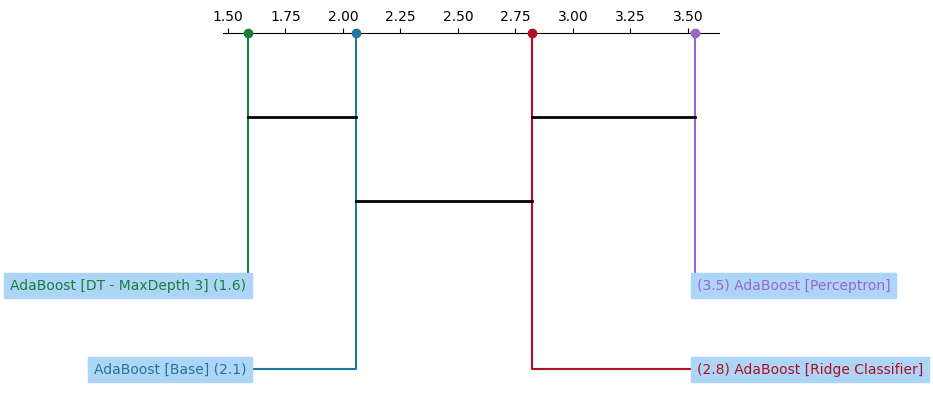

In [33]:
# Plotting tbe Critical Difference Diagram
weak_learner_modifications_matrix = Weak_Learner_Modifications_Results.drop(['Dataset'], axis=1)
colors = {'AdaBoost [Base]':'#1F7799', 'AdaBoost [DT - MaxDepth 3]':'#168039', 'AdaBoost [Perceptron]':'#9966cc', 'AdaBoost [Ridge Classifier]':'#AF1021'}
Plot_Critial_Difference_Diagram(weak_learner_modifications_matrix, colors)

> # REVISE THIS SECTION 
<div align="center">

--- 
### Loss Functions
---
</div>

In AdaBoost, loss functions play an important role in the Algorithm's performance. Each loss function has different properties and . Threfore we considered the following loss functions:

<div align="center">
    
---
#### Exponential Loss
---
</div>

By Default, the AdaBoost Algorithm uses this Loss Function. It focuses on increasing the weights of misclassified examples exponentially which makes the algorithm very sensitive to outliers and noise due to the fact that they are often harder to classify correctly and consequently get musch higher weights. However, it rapidly converges with risk to overfit onto noisy data and outliers.

##### $\rightarrow$ Loss Formula

$$L(y_i,f(x_i)) = e^{-y_i \cdot f(x_i)}$$

> Where $y_i$ is the true label and $f(x_i)$ is the predicted label

##### $\rightarrow$ Compute $\alpha's$

$$\alpha_m = \frac{1}{2} log(\frac{1 - error_m}{error_m})$$

> Where $error_m$ is the error of the current weak learner

##### $\rightarrow$ Update Weights

$$ w_i \leftarrow w_i \cdot \exp\left(\alpha_m \cdot I(y_i \neq G_m(x_i))\right) $$

> Where $y_i$ is the true label and $G_m(x_i)$ is the predicted label

<div align="center">

---
#### Logistic Loss
---
</div>

Logistic Loss is quite similar to logistic regression since it provides a more gradual increase on the penalties for misclassification. It is less sensitive to outliers compared to the Exponential Loss due to it's asymptotic growth which can lead to more robust generalizations specially in datasets with inherent noise and outliers.

##### $\rightarrow$ Loss Formula

$$L(y_i,f(x_i)) = log(1 + e^{-y_i \cdot f(x)})$$

> Where $y$ is the true label and $f(x_i)$ is the predicted label

##### $\rightarrow$ Compute $\alpha's$

$$\alpha_m = \frac{1}{2} log(\frac{1 - error_m}{error_m})$$

> Where $error_m$ is the error of the current weak learner

##### $\rightarrow$ Update Weights

$$ w_i \leftarrow w_i \cdot log( 1 + \exp\left(\alpha_m \cdot I(y_i \neq G_m(x_i))\right)) $$

> Where $y_i$ is the true label and $G_m(x_i)$ is the predicted label

<div align="center">

---
#### Hinge Loss
---
</div>

Commonly used in Support Vector Machines in classification, the Hinge Loss focuses on maximizing the margin between classes and penalizing only the points that lie in the wrong side of the decision boundary. Moreover, by focusing on the margin, this function can help AdaBoost be more robust against outliers and ensure that the classifier cerates a better general margin between classes.

##### $\rightarrow$ Loss Formula

$$L(y_i,f(x_i)) = max(0, 1 - y_i \cdot f(x_i))$$
> Where $y_i$ is the true label and $f(x_i)$ is the predicted label

##### $\rightarrow$ Compute $\alpha's$

$$\alpha_m = learning\_rate \cdot (1 - error_m)$$

> Where $error_m$ is the error of the current weak learner and $learning\_rate$ is a constant

##### $\rightarrow$ Update Weights

Define a set $I$ such that $I = \{ i ∣ y_i \cdot G_m(x_i)  < 1 \} $

$$ w_i \leftarrow w_i \cdot \exp(\alpha_m), \space \forall i \in I $$

> Where $y_i$ is the true label and $G_m(x_i)$ is the predicted label

<div align="center">

---
#### Squared Loss
---
</div>

Although traditionally used in regression, the Squared Loss function focuses on minimizing the squared errors between the predicted and real values. This loss function can be particularly useful because it emphasizes larger errors more significantly than smaller ones.

##### $\rightarrow$ Loss Formula

$$L(y_i,f(x_i)) = (1 - y_i \cdot f(x_i))^2$$

> Where $y_i$ is the true label and $f(x_i)$ is the predicted label

##### $\rightarrow$ Compute $\alpha's$

$$\alpha_m = learning\_rate \cdot (1 - error_m)$$

> Where $error_m$ is the error of the current weak learner and $learning\_rate$ is a constant

##### $\rightarrow$ Update Weights

$$ w_i \leftarrow w_i \cdot \exp(\alpha_m \cdot (1 - y_i \cdot G_m(x_i))^{2} $$

> Where $y_i$ is the true label and $G_m(x_i)$ is the predicted label

Therefore, by trying different Loss Functions we might be able to sucessfully improve the algorithm's performance.

In [11]:
try:
    Loss_Functions_Modifications_Results = pd.read_csv('./Experimental Results/AdaBoost_Loss_Functions_Modifications_Results.csv')
except:
    models = [AdaBoost(), AdaBoost_LogisticLoss(), AdaBoost_HingeLoss(), AdaBoost_SquaredLoss()]
    Loss_Functions_Modifications_Results = Evaluate_Models(my_tasks, models, ['Dataset','AdaBoost [Base]', 'AdaBoost [Logistic Loss]', 'AdaBoost [Hinge Loss]', 'AdaBoost [Squared Loss]'])
    Loss_Functions_Modifications_Results.to_csv('./Experimental Results/AdaBoost_Loss_Functions_Modifications_Results.csv', index=False)

Loss_Functions_Modifications_Results

,Dataset,AdaBoost [Base],AdaBoost [Logistic Loss],AdaBoost [Hinge Loss],AdaBoost [Squared Loss]
0,kr-vs-kp,0.940859,0.940233,0.660509,0.904253
1,breast-w,0.963418,0.961926,0.941359,0.964856
2,credit-approval,0.872860,0.866718,0.863641,0.863641
3,credit-g,0.758000,0.757000,0.700000,0.717000
4,diabetes,0.769612,0.766972,0.746159,0.766998
5,spambase,0.933927,0.931319,0.844812,0.906756
6,tic-tac-toe,0.732755,0.741110,0.653458,0.735924
7,electricity,0.770635,0.767655,0.756864,0.762315
8,pc4,0.893019,0.898510,0.877943,0.877943
9,pc3,0.895072,0.896991,0.897630,0.897630


> ## Add a FriedMan Test as well

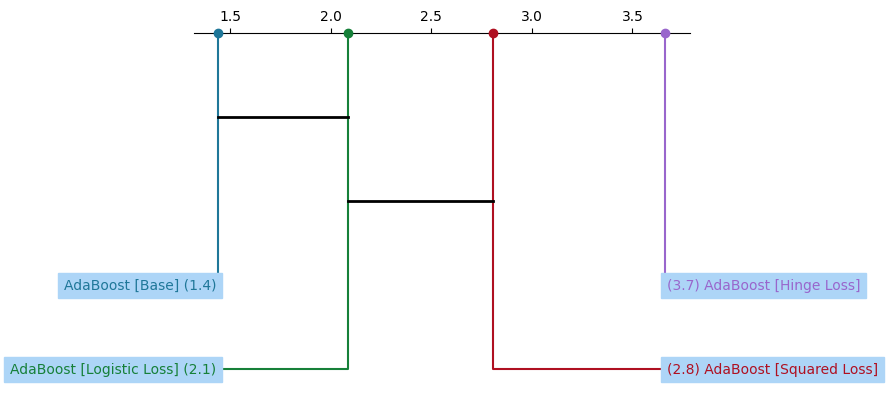

In [12]:
# Plotting tbe Critical Difference Diagram
loss_functions_modifications_matrix = Loss_Functions_Modifications_Results.drop(['Dataset'], axis=1)
colors = {'AdaBoost [Base]':'#1F7799', 'AdaBoost [Logistic Loss]':'#168039', 'AdaBoost [Hinge Loss]':'#9966cc', 'AdaBoost [Squared Loss]':'#AF1021'}
Plot_Critial_Difference_Diagram(loss_functions_modifications_matrix, colors)

---

In [12]:
# IDEA: PLOT ROC CURVE & AUC, CONFUSION MATRIX.
# LATER: 
# -> ADD A PAIR PLOT TO COMPARE THE DIFFERENCES BETWEEN BOTH ALGORITHMS (ORIGINAL AND MODIFIED)
# -> ADD A CRITIAL DIFERENCE REGION

---

> ## RERUN ALL EXPERIMENTS

---
## Tests [REMOVE LATER]

### MODEL EVALUATION

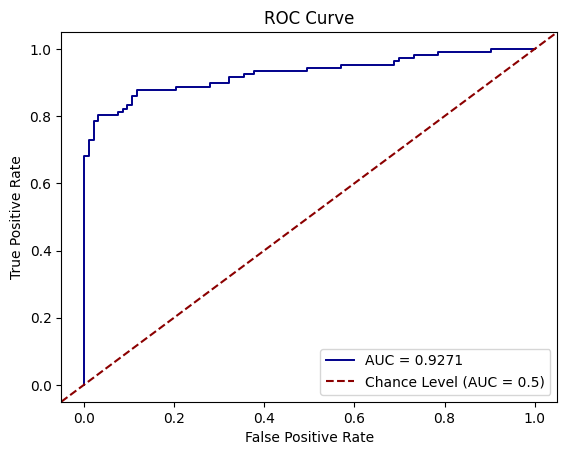

In [16]:
# Generate classification dataset
X, y = make_classification(n_samples= 1000, n_features = 20, random_state = 42)
y = y * 2 - 1       # Original AdaBoost uses {1, -1} as class labels

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Fit model
ab = AdaBoost_LogisticLoss()
# ab = AdaBoost(loss_function='logistic')
# ab = AdaBoost(loss_function='hinge')
# ab = AdaBoost(loss_function='squared')

ab.fit(X_train, y_train, M=400)

Plot_ROC_Curve(ab, X_test, y_test)
# Display_Confusion_Matrix(ab, X_test, y_test, np.unique(y))

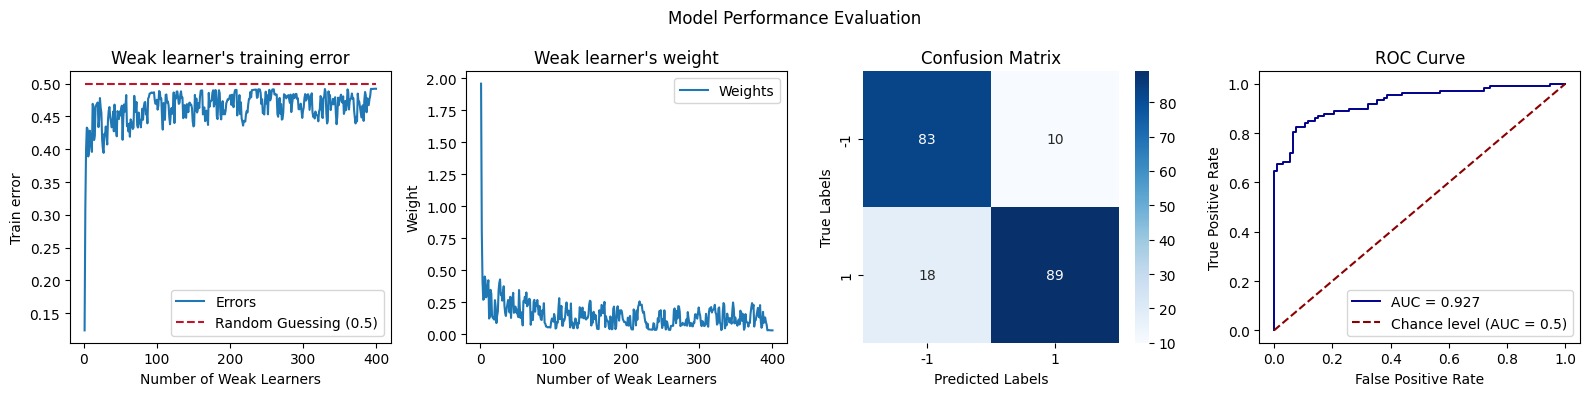

In [13]:
# Weak Learners Statistics
Plot_Model_Stats(ab, X_test, y_test)

In [ ]:
# Sklearn Base AdaBoost
# model = AdaBoostClassifier()
# Evaluate_Model_AllDS(my_tasks, model)

# Base Model Implementation
# model = AdaBoost()
# Evaluate_Model_AllDS(my_tasks, model)

# Modified AdaBoost with Perceptron
# model = AdaBoostPerceptron()
# Evaluate_Model_AllDS(my_tasks, model)

In [ ]:
# Plot Model's Accuracies alonside K-Fold CV
# Compare_Models_Accuracies(X, y, [AdaBoost(), AdaBoostPerceptron()], ['AdaBoost [Base]', 'AdaBoost [Perceptron]'], ['#1F7799', '#bd162c'])

In [ ]:
# model1 = AdaBoost()
# model1.fit(X_train, y_train, M=400)
# 
# model2 = AdaBoostPerceptron()
# model2.fit(X_train, y_train, M=400)
# 
# model3 = AdaBoostSGD()
# model3.fit(X_train, y_train, M=400)
# 
# models = [model1, model2, model3]
# model_names = ['AdaBoost [Base]', 'AdaBoost [Perceptron]', 'AdaBoost [SGD]']

# Compare_Models_Stats(models, model_names, X_test, y_test)

### CRITICAL DIFFERENCES - PLOTS

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.datasets import load_iris

# Load data
data = load_iris()
X = data.data
y = data.target

# Define models
model1 = RandomForestClassifier(random_state=1)
model2 = AdaBoostClassifier(random_state=1)

def Calculate_PValue(FirstModel, SecondModel, X, y, total_permutations=100):
    # Compute observed accuracies
    FirstModelAccuracies = cross_val_score(FirstModel, X, y, cv=5)
    SecondModelAccuracies = cross_val_score(SecondModel, X, y, cv=5)
    
    # Observed difference
    obs_diff = np.abs(np.mean(FirstModelAccuracies) - np.mean(SecondModelAccuracies))
    
    # Initialize a counter
    count = 0
    
    for _ in range(total_permutations):
        # Shuffle the labels
        np.random.shuffle(y)
        
        # Compute new accuracies
        NewFirstModelAccuracies = cross_val_score(FirstModel, X, y, cv=5)
        NewSecondModelAccuracies = cross_val_score(SecondModel, X, y, cv=5)
        
        # Compute difference
        new_diff = np.abs(np.mean(NewFirstModelAccuracies) - np.mean(NewSecondModelAccuracies))
        
        # Count how many times the permuted difference is greater than the observed difference
        if new_diff >= obs_diff:
            count += 1
    
    # Calculate p-value
    p_value = count / total_permutations

    return p_value

print("P-value:", Calculate_PValue(model1, model2, X, y, 50))

<div align="center">

***
## Bibliographic References
***
</div>

1. Cano. Alvaro (Towards Data Science, 2021). __*AdaBoost from Scratch*__. Available [here](https://towardsdatascience.com/adaboost-from-scratch-37a936da3d50)
2. Geeks For Geeks (2023). __*Boosting in Machine Learning | Boosting and AdaBoost*__. Available [here](https://www.geeksforgeeks.org/boosting-in-machine-learning-boosting-and-adaboost/)
3. Geeks For Geeks (2024). __*Implementing the AdaBoost Algorithm from Scratch*__. Available [here](https://www.geeksforgeeks.org/implementing-the-adaboost-algorithm-from-scratch/)

___
## Final Considerations

$\quad$ If there is any difficulty on downloading or executing this project, please contact us via:

- **Email**:
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@up.pt`
    - [Nuno Gomes](https://github.com/NightF0x26) &#8594; `up202206195@up.pt`